Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from six.moves import cPickle as pickle
%matplotlib inline  

First reload the data we generated in _notmist.ipynb_.

In [2]:
pickle_file = os.path.join('data','notMNIST.pickle')

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Validation set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
    # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [5]:
def plot_accuracy(betas,accuracy):
    plt.plot(betas, accuracy)
    plt.xlabel('Beta')
    plt.ylabel('Accuracy (%)')
    plt.xscale('log')
    plt.title('Accuracy')
    plt.grid(True)
    plt.show()

### Logistic model ###

In [6]:
batch_size = 128
graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
    biases = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)

    # Training computation.
    logits = tf.matmul(tf_train_dataset, weights) + biases
    regularizers =  beta * tf.nn.l2_loss(weights)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + regularizers 
    
    # Optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(tf.matmul(tf_valid_dataset, weights) + biases)
    test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001
report_freq = 500
beta_pow_range = np.arange(-4,-1,0.1)
beta_grid = [10**i for i in beta_pow_range]
accuracy_values = np.zeros(len(beta_grid))

train_accuracy = np.zeros(num_steps / report_freq + 1)
valid_accuracy = np.zeros(num_steps / report_freq + 1)

for index, current_beta in enumerate(beta_grid):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:current_beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % report_freq == 0):
                train_accuracy[step/report_freq] = accuracy(predictions, batch_labels)
                valid_accuracy[step/report_freq] = accuracy(valid_prediction.eval(), valid_labels)        
            if (step == num_steps-1):
                accuracy_values[index] = accuracy(test_prediction.eval(), test_labels)


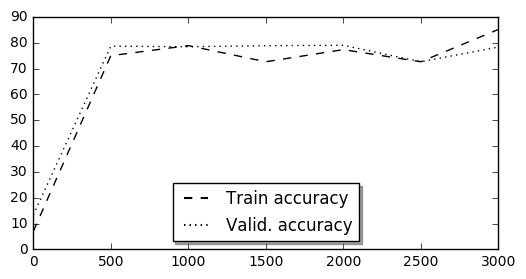

In [8]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
y_labels = range(0,num_steps,report_freq)
ax.plot(y_labels, train_accuracy, 'k--', label='Train accuracy')
ax.plot(y_labels, valid_accuracy, 'k:', label='Valid. accuracy')

legend = ax.legend(loc='lower center', shadow=True)

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.show()

Max accuracy: 88.9%
Optimal Beta: 1e-03


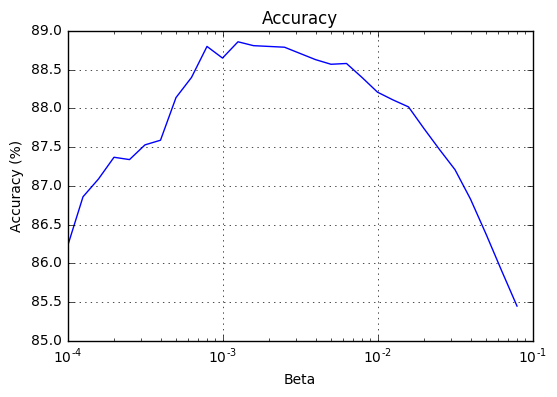

In [9]:
print("Max accuracy: %.1f%%" % np.max(accuracy_values))
print("Optimal Beta: %.e" % beta_grid[np.argmax(accuracy_values)])

plot_accuracy(beta_grid,accuracy_values)

### Neural network ###

In [10]:
batch_size = 128
n_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_layer1 = tf.Variable(tf.truncated_normal([image_size * image_size, n_nodes]))
    biases_layer1 = tf.Variable(tf.zeros([n_nodes]))
    
    weights_layer2 = tf.Variable(tf.truncated_normal([n_nodes, num_labels]))
    biases_layer2 = tf.Variable(tf.zeros([num_labels]))
    beta = tf.placeholder(tf.float32)
    
    # Training computation.
    layer1 = tf.nn.relu(tf.matmul(tf_train_dataset, weights_layer1) + biases_layer1)
    logits = tf.matmul(layer1, weights_layer2) + biases_layer2
    regularizers = beta * (tf.nn.l2_loss(weights_layer1) + tf.nn.l2_loss(weights_layer2))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + regularizers) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer1) + biases_layer1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_layer, weights_layer2) + biases_layer2)
    test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer1) + biases_layer1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer, weights_layer2) + biases_layer2)

In [11]:
num_steps = 3001
beta_pow_range = np.arange(-4,-1,0.1)
beta_grid = [10**i for i in beta_pow_range]
accuracy_values = np.zeros(len(beta_grid))

for index, current_beta in enumerate(beta_grid):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        for step in range(num_steps):
            offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
            batch_data = train_dataset[offset:(offset + batch_size), :]
            batch_labels = train_labels[offset:(offset + batch_size), :]
            feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:current_beta}
            _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
            if (step % report_freq == 0):
                train_accuracy[step/report_freq] = accuracy(predictions, batch_labels)
                print("Minibatch loss at step %d: %f" % (step, l))
                print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
                print("Validation accuracy: %.1f%%" % accuracy(valid_prediction.eval(), valid_labels))
            if (step == num_steps -1 ):
                accuracy_values[index] = accuracy(test_prediction.eval(), test_labels)
                print("Test accuracy: %.1f%%" % accuracy_values[index])


Minibatch loss at step 0: 379.264404
Minibatch accuracy: 10.9%
Validation accuracy: 18.9%
Minibatch loss at step 500: 46.503574
Minibatch accuracy: 82.0%
Validation accuracy: 79.6%
Minibatch loss at step 1000: 31.461372
Minibatch accuracy: 89.1%
Validation accuracy: 81.0%
Minibatch loss at step 1500: 30.917301
Minibatch accuracy: 78.9%
Validation accuracy: 81.5%
Minibatch loss at step 2000: 26.858028
Minibatch accuracy: 83.6%
Validation accuracy: 82.2%
Minibatch loss at step 2500: 26.595844
Minibatch accuracy: 84.4%
Validation accuracy: 80.9%
Minibatch loss at step 3000: 24.181896
Minibatch accuracy: 84.4%
Validation accuracy: 82.9%
Test accuracy: 89.6%
Minibatch loss at step 0: 429.334900
Minibatch accuracy: 14.8%
Validation accuracy: 24.2%
Minibatch loss at step 500: 45.702770
Minibatch accuracy: 81.2%
Validation accuracy: 81.9%
Minibatch loss at step 1000: 37.097530
Minibatch accuracy: 89.1%
Validation accuracy: 82.1%
Minibatch loss at step 1500: 35.091751
Minibatch accuracy: 82.8%


Max accuracy: 93.3%
Optimal Beta: 2e-03


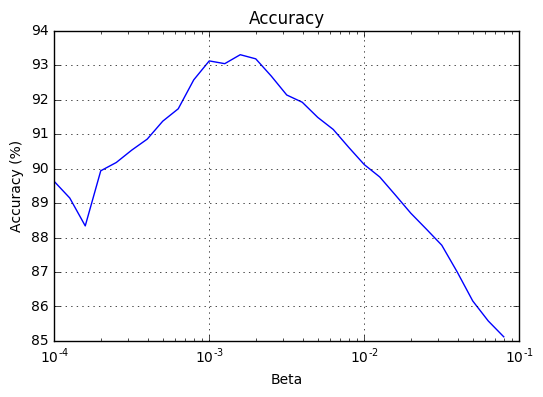

In [12]:
print("Max accuracy: %.1f%%" % np.max(accuracy_values))
print("Optimal Beta: %.e" % beta_grid[np.argmax(accuracy_values)])

plot_accuracy(beta_grid,accuracy_values)

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [13]:
report_freq = 50
num_steps = 1001

train_accuracy = np.zeros(num_steps / report_freq + 1)
valid_accuracy = np.zeros(num_steps / report_freq + 1)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        #Let' train on the three first batches only
        offset = (step * batch_size) % (batch_size * 3)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:1e-03}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % report_freq == 0):
            train_accuracy[step/report_freq] = accuracy(predictions, batch_labels)
            valid_accuracy[step/report_freq] = accuracy(test_prediction.eval(), test_labels)        
        if (step == num_steps-1):
            print("test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))


test accuracy: 78.8%


100% reached at step 50


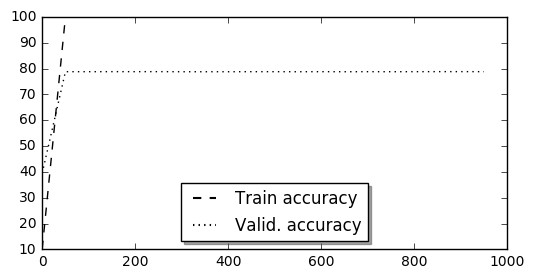

In [14]:
position =  (np.where(train_accuracy==100)[0][0])
print("100% reached at step " + str(position*50))
fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
ax.plot(range(0,1000,50), train_accuracy[:20], 'k--', label='Train accuracy')
ax.plot(range(0,1000,50), valid_accuracy[:20], 'k:', label='Valid. accuracy')

legend = ax.legend(loc='lower center', shadow=True)

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.show()

Accuracy on training set reaches rapidly 100% but testing and validation accuracy are much lower.

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [15]:
batch_size = 128
n_nodes = 1024

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, image_size * image_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    beta = tf.placeholder(tf.float32)
    weights_layer1 = tf.Variable(tf.truncated_normal([image_size * image_size, n_nodes]))
    biases_layer1 = tf.Variable(tf.zeros([n_nodes]))
    
    weights_layer2 = tf.Variable(tf.truncated_normal([n_nodes, num_labels]))
    biases_layer2 = tf.Variable(tf.zeros([num_labels]))

    keep_prob = tf.placeholder(tf.float32)
    # Training computation.
    layer1 = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_layer1) + biases_layer1), keep_prob)
    logits = tf.matmul(layer1, weights_layer2) + biases_layer2
    regularizers = beta * (tf.nn.l2_loss(weights_layer1) + tf.nn.l2_loss(weights_layer2))
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels) + regularizers) 

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_hidden_layer = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_layer1) + biases_layer1)
    valid_prediction = tf.nn.softmax(tf.matmul(valid_hidden_layer, weights_layer2) + biases_layer2)
    test_hidden_layer = tf.nn.relu(tf.matmul(tf_test_dataset, weights_layer1) + biases_layer1)
    test_prediction = tf.nn.softmax(tf.matmul(test_hidden_layer, weights_layer2) + biases_layer2)

In [16]:
report_freq = 50
num_steps = 1001

train_accuracy = np.zeros(num_steps / report_freq + 1)
test_accuracy = np.zeros(num_steps / report_freq + 1)
valid_accuracy = np.zeros(num_steps / report_freq + 1)
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        #Let' train on the three first batches only
        offset = (step * batch_size) % (batch_size * 3)
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict_train = {tf_train_dataset: batch_data, tf_train_labels: batch_labels, beta:2e-03, keep_prob:0.5}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict_train)
        if (step % report_freq == 0):
            train_accuracy[step/report_freq] = accuracy(predictions, batch_labels)
            test_accuracy[step/report_freq] = accuracy(test_prediction.eval(), test_labels)        
        if (step == num_steps -1 ):
            print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
        

Test accuracy: 84.5%


100% reached at step 150


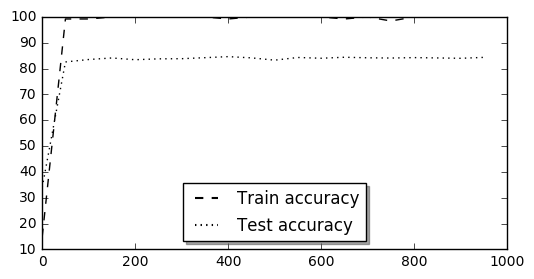

In [17]:
position =  (np.where(train_accuracy==100)[0][0])
print("100% reached at step " + str(position*50))
fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
ax.plot(range(0,1000,50), train_accuracy[:20], 'k--', label='Train accuracy')
ax.plot(range(0,1000,50), test_accuracy[:20], 'k:', label='Test accuracy')

legend = ax.legend(loc='lower center', shadow=True)

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.show()

100% accuracy on the training set comes later (step 400 instead of 200) and final test accuracy is a bit higher, but not significantly.
As noted on [Tensoflow.org](https://www.tensorflow.org/versions/r0.10/tutorials/mnist/pros/index.html): 
> Dropout is often very effective at reducing overfitting, but it is most useful when training very large neural networks.

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Since the model becomes more complex I want to avoid having to write it three times (train, valid, test). Instead, I will define its graph once and use `feed_dict` to feed it with train, validation, and test data.

In [18]:
num_steps = 100001
batch_size = 128
hidden = [1024, 256, 128]

graph = tf.Graph()
with graph.as_default():
    b_size = tf.placeholder(tf.int32)
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    # Note the dynamic shape of data and labels that allows us to feed the model with difference
    # batch size at training and at testing
    data = tf.placeholder(tf.float32, shape=(None, image_size * image_size))
    labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    
    # Variables.
    global_step = tf.Variable(0, trainable=False)
    beta = tf.placeholder(tf.float32)

    weights0 = tf.Variable(
        tf.truncated_normal([image_size ** 2, hidden[0]], stddev=np.sqrt(2.0 / (image_size ** 2))))
    weights1 = tf.Variable(
        tf.truncated_normal([hidden[0], hidden[1]], stddev=np.sqrt(2.0 / hidden[0])))
    weights2 = tf.Variable(
        tf.truncated_normal([hidden[1], hidden[2]], stddev=np.sqrt(2.0 / hidden[1])))
    weights_logits = tf.Variable(
        tf.truncated_normal([hidden[2], num_labels], stddev=np.sqrt(2.0 / hidden[2])))

    biases0 = tf.Variable(tf.zeros([hidden[0]]))
    biases1 = tf.Variable(tf.zeros([hidden[1]]))
    biases2 = tf.Variable(tf.zeros([hidden[2]]))
    biases_logits = tf.Variable(tf.zeros([num_labels]))
    keep_prob = tf.placeholder(tf.float32)

    # Layers
    train_layer0 = tf.nn.dropout(tf.nn.relu(tf.matmul(data, weights0) + biases0), keep_prob=keep_prob)
    train_layer1 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_layer0, weights1) + biases1), keep_prob=keep_prob)
    train_layer2 = tf.nn.dropout(tf.nn.relu(tf.matmul(train_layer1, weights2) + biases2), keep_prob=keep_prob)
    logits = tf.matmul(train_layer2, weights_logits) + biases_logits

    regularizers = beta * (tf.nn.l2_loss(weights0)
                           + tf.nn.l2_loss(weights1)
                           + tf.nn.l2_loss(weights2)
                           + tf.nn.l2_loss(weights_logits))

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, labels) + regularizers)

    learning_rate = tf.train.exponential_decay(0.3, global_step, 4000, 0.5, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # model evaluation
    preds = tf.nn.softmax(logits)
    correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(labels, 1))
    batch_accuracy = tf.reduce_mean(tf.cast(correct_preds, tf.float32))

In [19]:
report_freq = 500

train_accuracy = np.zeros(num_steps / report_freq + 1)
test_accuracy = np.zeros(num_steps / report_freq + 1)
valid_accuracy = np.zeros(num_steps / report_freq + 1)
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        
        feed_dict_train = {
            data: train_dataset[offset:(offset + batch_size), :],
            labels: train_labels[offset:(offset + batch_size), :],
            beta: 1e-03, 
            keep_prob:0.5
        }
        
        # We only need to run the back prop so we don't fetch anything else to avoid unnecessary computations
        session.run(optimizer, feed_dict = feed_dict_train)
        
        if (step % report_freq == 0):
            # We want to evaluate the model, so this time we don't want to run the back prop 
            # (notice optimizer is not fetched). 
            # Instead we want to evaluate the loss and accuracy with current weights
            l, t_accuracy = session.run([loss, batch_accuracy], feed_dict=feed_dict_train)

            # Create a dict to feed the model with the whole validation data, not just a batch.
            # Notice keep_prob = 1 to avoid dropout.
            feed_dict_valid={
                        data: valid_dataset,
                        labels: valid_labels,
                        beta: 1e-03, 
                        keep_prob: 1
            }
            
            # Now we run the model with the validation data to obtain the accuracy on the validation batch.
            v_accuracy= session.run(batch_accuracy,feed_dict=feed_dict_valid)            

            train_accuracy[step/report_freq] = t_accuracy * 100
            valid_accuracy[step/report_freq] = v_accuracy * 100
            
            print("\nMinibatch loss at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" %  (t_accuracy * 100))
            print("Validation accuracy: %.1f%%" % (v_accuracy * 100))
            
        if (step == num_steps - 1):
            feed_dict_test={
                        data: test_dataset, # here we feed the whole test test, not just a batch
                        labels: test_labels,
                        beta: 1e-03, 
                        keep_prob: 1
            }
            
            print("\nTest accuracy: %.1f%%" % (session.run(batch_accuracy, feed_dict=feed_dict_test) * 100))



Minibatch loss at step 0: 3.388400
Minibatch accuracy: 19.5%
Validation accuracy: 14.6%

Minibatch loss at step 500: 1.345516
Minibatch accuracy: 85.9%
Validation accuracy: 84.3%

Minibatch loss at step 1000: 0.975314
Minibatch accuracy: 89.8%
Validation accuracy: 85.7%

Minibatch loss at step 1500: 1.089051
Minibatch accuracy: 85.2%
Validation accuracy: 86.3%

Minibatch loss at step 2000: 0.860992
Minibatch accuracy: 85.9%
Validation accuracy: 86.5%

Minibatch loss at step 2500: 0.855735
Minibatch accuracy: 85.2%
Validation accuracy: 87.1%

Minibatch loss at step 3000: 0.561092
Minibatch accuracy: 93.0%
Validation accuracy: 87.2%

Minibatch loss at step 3500: 0.677770
Minibatch accuracy: 86.7%
Validation accuracy: 87.2%

Minibatch loss at step 4000: 0.920658
Minibatch accuracy: 78.9%
Validation accuracy: 87.4%

Minibatch loss at step 4500: 0.687389
Minibatch accuracy: 87.5%
Validation accuracy: 88.5%

Minibatch loss at step 5000: 0.594819
Minibatch accuracy: 85.9%
Validation accuracy

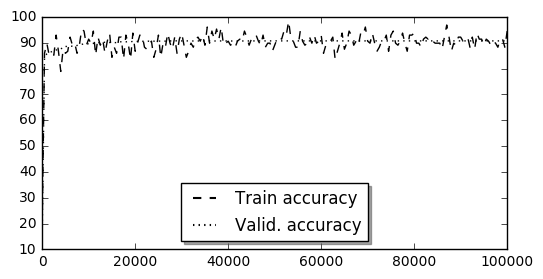

In [20]:
fig, ax = plt.subplots(figsize=(6, 3), dpi=80)
ax.plot(range(0,num_steps,report_freq), train_accuracy, 'k--', label='Train accuracy')
ax.plot(range(0,num_steps,report_freq), valid_accuracy, 'k:', label='Valid. accuracy')

legend = ax.legend(loc='lower center', shadow=True)

for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.show()